In [46]:
import datetime
import os
import pprint
import tempfile
from typing import Dict, Text

import numpy as np
import pandas as pd
import seaborn as sns
import surprise
import tensorflow as tf
import tensorflow_recommenders as tfrs
import tensorflow_datasets as tfds

import mlflow

# Data

## Read Data and EDA

In [6]:
df_raw = pd.read_csv("../content_engagement.csv")

In [7]:
df_raw.head()

,user_id,content_id,event_timestamp,event_type
0,1438eb1414,f260f3f3ce,1.642347e+09,viewed
1,5380d76552,f260f3f3ce,1.642538e+09,viewed
2,f600b96610,f260f3f3ce,1.643294e+09,engaged
3,395ee54b4e,bce874342a,1.642697e+09,viewed
4,dcbb8d2a04,f260f3f3ce,1.641336e+09,viewed


In [8]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484077 entries, 0 to 484076
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   user_id          484077 non-null  object 
 1   content_id       484077 non-null  object 
 2   event_timestamp  484077 non-null  float64
 3   event_type       484077 non-null  object 
dtypes: float64(1), object(3)
memory usage: 14.8+ MB


In [9]:
df_raw.describe()

,event_timestamp
count,4.840770e+05
mean,1.642165e+09
std,1.363745e+06
min,1.639552e+09
25%,1.641059e+09
50%,1.642280e+09
75%,1.643377e+09
max,1.644304e+09


In [10]:
for col in df_raw.columns:
    print("-----------")
    print("Column: ", col)
    print(df_raw.groupby(col)[col].count().sort_values(ascending=False))

-----------
Column:  user_id
user_id
0d19aee850    851
7be8a15624    747
eaba11e509    683
f8ac1fda3e    635
89fd239a24    595
             ... 
d38665f69c     10
6e7fc0ac77      9
bd67a44280      7
9bc19b73da      5
317806d756      5
Name: user_id, Length: 7252, dtype: int64
-----------
Column:  content_id
content_id
e177042e25    4217
b9c3dbfb01    3891
563c1fdf8f    3606
34caa29b86    3509
2886fad498    3492
              ... 
ef26487db1     160
bb3c04c6e7     158
62c77cff65     152
49967babeb     134
a955421740     122
Name: content_id, Length: 583, dtype: int64
-----------
Column:  event_timestamp
event_timestamp
1.642627e+09    20
1.643759e+09    13
1.644028e+09    13
1.643776e+09    10
1.643987e+09     6
                ..
1.641654e+09     1
1.641654e+09     1
1.641654e+09     1
1.641654e+09     1
1.644304e+09     1
Name: event_timestamp, Length: 393488, dtype: int64
-----------
Column:  event_type
event_type
viewed     292033
engaged    192044
Name: event_type, dtype: int64


In [11]:
df_raw["event_type"].value_counts(normalize=True)

viewed     0.603278
engaged    0.396722
Name: event_type, dtype: float64

## Feature Engineer

In [12]:
# add features for deep learning model
# day of the week

In [13]:
# all user_id and content_id combinations
df_raw.groupby(["user_id", "content_id"]).size().reset_index(name="counts")

,user_id,content_id,counts
0,000a544834,34caa29b86,1
1,000a544834,3d0e786812,1
2,000a544834,5c7ee2dd80,2
3,000a544834,6f7ca40e85,2
4,000a544834,745115bd62,1
...,...,...,...
197557,fff5c815f7,b11fec4c92,1
197558,fff5c815f7,b2f77c9143,3
197559,fff5c815f7,bed9cfbff5,1
197560,fff5c815f7,c29f53db23,1


In [14]:
# create a column for the number of times content was viewed
df_viewed = (
    df_raw.groupby(["user_id", "content_id"])["event_type"]
    .apply(lambda x: (x == "viewed").sum())
    .reset_index(name="viewed_count")
)
df_viewed

,user_id,content_id,viewed_count
0,000a544834,34caa29b86,1
1,000a544834,3d0e786812,1
2,000a544834,5c7ee2dd80,1
3,000a544834,6f7ca40e85,2
4,000a544834,745115bd62,1
...,...,...,...
197557,fff5c815f7,b11fec4c92,1
197558,fff5c815f7,b2f77c9143,1
197559,fff5c815f7,bed9cfbff5,1
197560,fff5c815f7,c29f53db23,1


In [15]:
# create a column for the number of times content was engaged with
df_engaged = (
    df_raw.groupby(["user_id", "content_id"])["event_type"]
    .apply(lambda x: (x == "engaged").sum())
    .reset_index(name="engaged_count")
)

In [16]:
df_engaged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197562 entries, 0 to 197561
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        197562 non-null  object
 1   content_id     197562 non-null  object
 2   engaged_count  197562 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 4.5+ MB


In [17]:
df = pd.merge(df_viewed, df_engaged, on=["user_id", "content_id"], how="inner")

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197562 entries, 0 to 197561
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        197562 non-null  object
 1   content_id     197562 non-null  object
 2   viewed_count   197562 non-null  int64 
 3   engaged_count  197562 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 7.5+ MB


In [19]:
# can have instances where engaged count is higher than viewed count. Must add the two columns to get a total number of times a user has seen content
df[(df["viewed_count"] == 0) & (df["engaged_count"] > 0)]

,user_id,content_id,viewed_count,engaged_count
23,000d2a6006,639ae113f9,0,1
26,000d2a6006,86091a3dd6,0,1
29,000d2a6006,8b93c4122b,0,1
35,000d2a6006,bd1201fb2a,0,1
84,00203a8599,7a46fa6591,0,1
...,...,...,...,...
197490,ffd71a9c58,92bf3d3306,0,1
197491,ffd71a9c58,92d02e39af,0,1
197505,ffd71a9c58,eb6db21a94,0,2
197515,ffe8882b5f,bed9cfbff5,0,1


In [20]:
df["shown_count"] = df["engaged_count"] + df["viewed_count"]

In [21]:
df["engaged_pct"] = df["engaged_count"] / df["shown_count"]

In [22]:
# there are some combinations of user_id and content_id that aren't ingaged with.
df.describe()

,viewed_count,engaged_count,shown_count,engaged_pct
count,197562.000000,197562.000000,197562.000000,197562.000000
mean,1.478184,0.972070,2.450254,0.363707
std,1.182726,1.057802,1.653833,0.349768
min,0.000000,0.000000,1.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000
50%,1.000000,1.000000,2.000000,0.333333
75%,2.000000,2.000000,3.000000,0.600000
max,61.000000,33.000000,65.000000,1.000000


In [23]:
# evaluate engaged pct
df.groupby("engaged_pct").size().reset_index(name="count").sort_values(by="count")

,engaged_pct,count
66,0.619048,1
91,0.923077,1
37,0.352941,1
35,0.310345,1
52,0.470588,1
...,...,...
36,0.333333,16001
71,0.666667,16865
92,1.000000,25993
53,0.500000,39276


In [24]:
df.sort_values(by="engaged_pct")

,user_id,content_id,viewed_count,engaged_count,shown_count,engaged_pct
0,000a544834,34caa29b86,1,0,1,0.0
102574,871f8b4bb4,5a5ad99eed,2,0,2,0.0
102573,871f8b4bb4,5149306338,2,0,2,0.0
102571,871f8b4bb4,304b40d2ce,2,0,2,0.0
102570,871f8b4bb4,264877c95d,1,0,1,0.0
...,...,...,...,...,...,...
24709,202b6476c8,713c7bbbd1,0,1,1,1.0
134296,add81aadd2,7e5b252782,0,1,1,1.0
134297,add81aadd2,86091a3dd6,0,3,3,1.0
134273,add81aadd2,1226a12aab,0,1,1,1.0


In [25]:
# is any content not engaged with
content_engaged_max = (
    df.groupby("content_id")["engaged_count"]
    .max()
    .reset_index(name="count")
    .sort_values(by="count")
)  # .size()
print(
    "# of content_ids with were never engaged with: ",
    len(content_engaged_max[content_engaged_max["count"] == 0]),
)
content_engaged_max

# all content is engaged with by more than 1 user_id

# of content_ids with were never engaged with:  0


,content_id,count
311,87ec664a85,2
24,09826d4e9c,2
58,188782f32a,2
276,76e177d35f,2
49,14d63e1ccc,2
...,...,...
153,457028a884,14
9,03bc268791,14
580,ff34eb1057,17
353,99c6cf7932,32


In [45]:
# is any content not engaged with
user_engaged_max = (
    df.groupby("user_id")["engaged_count"]
    .max()
    .reset_index(name="count")
    .sort_values(by="count")
)  # .size()
print(
    "# of content_ids with were never engaged with: ",
    len(user_engaged_max[content_engaged_max["count"] == 0]),
    " out of ",
    len(user_engaged_max),
)
user_engaged_max

# of content_ids with were never engaged with:  186  out of  7252


,user_id,count
1425,33b31cf5aa,0
5978,d35768187e,0
6623,ea5054ca9d,0
3501,7e6b80f21f,0
4146,940682865c,0
...,...,...
4098,9218655d62,14
1693,3e5c7a3727,14
7102,faef37e4be,17
5983,d39bca4a9c,32


## Visualize

<AxesSubplot:title={'center':'distribution'}, ylabel='Frequency'>

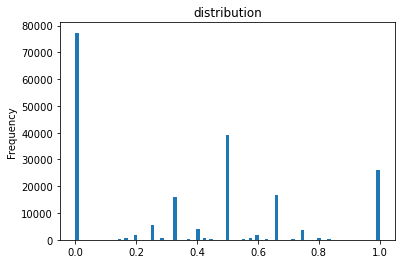

In [26]:
df["engaged_pct"].plot.hist(bins=len(df["engaged_pct"].unique()), title="distribution")

<AxesSubplot:title={'center':'distribution'}, ylabel='Frequency'>

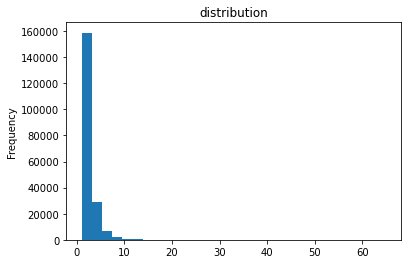

In [27]:
df["shown_count"].plot.hist(bins=len(df["shown_count"].unique()), title="distribution")

<AxesSubplot:title={'center':'distribution'}, ylabel='Frequency'>

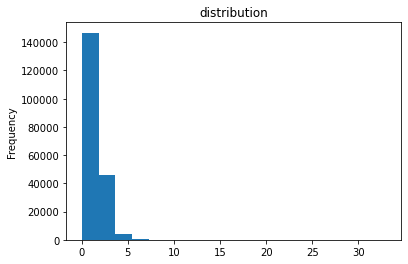

In [28]:
df["engaged_count"].plot.hist(
    bins=len(df["engaged_count"].unique()), title="distribution"
)

In [29]:
df_content = pd.DataFrame(df.groupby("content_id")["engaged_pct"].mean())

In [30]:
df_content["count"] = df.groupby("content_id")["engaged_pct"].count()

In [31]:
df_content.head()

,engaged_pct,count
content_id,,
00733d9430,0.593709,275
008c372b81,0.147482,139
01af663e58,0.544432,344
024775977e,0.419253,174
02538907fb,0.498389,102


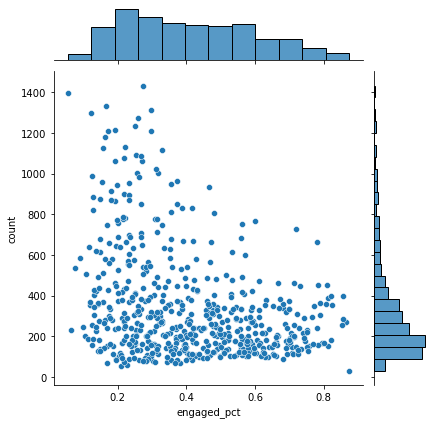

In [32]:
sns.jointplot(x="engaged_pct", y="count", data=df_content)

In [33]:
df.head()
df.value_counts("engaged_pct")

engaged_pct
0.000000    77320
0.500000    39276
1.000000    25993
0.666667    16865
0.333333    16001
            ...  
0.588235        1
0.235294        1
0.619048        1
0.627451        1
0.058824        1
Length: 93, dtype: int64

In [34]:
df.pivot_table(index="user_id", columns="content_id", values="engaged_pct")

content_id,00733d9430,008c372b81,01af663e58,024775977e,02538907fb,02a1c31249,02c1e6d1c0,02d4994f74,03771ad6ff,03bc268791,...,f8642357c4,f8a7e48e23,f8e78525fc,fa35bf073a,fa40c57163,fca013584c,fe3f5a2350,ff34eb1057,ff366a51d0,ffbc4f3fa0
user_id,,,,,,,,,,,,,,,,,,,,,
000a544834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000d2a6006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
001dba467f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
001f0b81ec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0020032d22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffe8882b5f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ffecf65324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fff0532cdb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
total = 7252 * 583
total
# 4,227,916

In [40]:
shape = df[["user_id", "content_id", "engaged_pct"]].shape
shape
# 197,562

(197562, 3)

In [47]:
sparsity = shape[0] / total
sparsity

0.04672798608108581